In [80]:
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms


In [81]:
class LinearRegression:

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X / (np.amax(y))
        self.y_train = y / (np.amax(y))
        self.N_train = X.shape[0]
        self.M = X.shape[1]


    def to_int_tpl_map(self, line):
        return tuple(map(int, line.strip().split()))


    def fit_from_file(self, file_name=None, file=None):
        if file_name:
            file = open(file_name)
        raw_data = tuple(map(self.to_int_tpl_map, file.readlines()))
        self.M = int(raw_data[0][0])
        self.N_train = int(raw_data[1][0])
        train_data = np.array(raw_data[2:self.N_train+2])
        self.y_train = train_data[:, -1] / np.amax(train_data[:, -1])
        self.X_train = train_data[:,:-1] / np.amax(train_data[:, -1])
        self.N_test = int(raw_data[self.N_train+2][0])
        test_data = np.array(raw_data[self.N_train+3:])
        self.y_test = test_data[:,-1]
        self.X_test = test_data[:,:-1]


    def rmse_loss(self, y_pred):
        return np.sqrt((((y_pred - self.y_train)**2).sum())/self.N_train)

    def SVD(self):
        self.w = np.linalg.pinv(self.X_train) @ self.y_train


    def gradient(self, lr=0.01, batch_size=75, n_epochs=100000):

        def loss_derivative(y, y_pred):
            return -2 * (y - y_pred)
        self.w = np.random.sample(self.M)
        for it in range(n_epochs):
            if it % batch_size == 0:
                y_pred = self.X_train @ self.w
                loss_der = loss_derivative(self.y_train, y_pred)
                grad = (np.array([self.X_train[n]*loss_der[n] for n in range(self.N_train)])).sum(axis=0)/self.N_train
                # print('grad:', ' '.join(map(str, grad)))
            self.w = self.w - lr * grad


    def genetic(self, n_epochs=40):
        creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_float", np.random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=self.M)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_def(individual):
            return self.rmse_loss(self.X_train @ individual),

        toolbox.register("evaluate", eval_def)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        population = toolbox.population(n=300)

        for gen in range(n_epochs):
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population = toolbox.select(offspring, k=len(population))
        self.w = tools.selBest(population, k=1)[0]


    def nrmse_score(self, X_test=None, y_test=None):
        if X_test:
            self.X_test = X_test
        if X_test:
            self.y_test = y_test
        y_pred = self.X_test @ self.w
        return np.sqrt(((y_pred - self.y_test)**2).sum()/self.y_test.shape[0])/(np.amax(self.y_test) - np.amin(self.y_test))


    def smape_score(self, X_test=None, y_test=None):
        if X_test and y_test:
            self.X_test = np.array(X_test)
            self.y_test = np.array(y_test)
            self.N_test = self.y_test.shape[0]
        y_pred = self.X_test  @ self.w
        return (100/self.N_test) * (np.absolute(self.y_test - y_pred)/(np.absolute(self.y_test) + np.absolute(y_pred))).sum()


In [82]:
reg = LinearRegression()
reg.fit_from_file("6.txt")

In [83]:
reg.SVD()
print(reg.smape_score())

0.392584289961708


In [91]:
grad_res = []
for n_epochs in [100, 500, 1000, 10000, 100000]:
    for batch_size in [100, 75, 50, 20, 10, 5 ,1]:
        for lr in 10.**np.arange(-4, -1):
            reg.gradient(lr=lr, batch_size=batch_size, n_epochs=n_epochs)
            smape = reg.smape_score()
            nrmse = reg.nrmse_score()
            grad_res.append([lr, batch_size, n_epochs, smape, nrmse])
            # print('gradient: lr_%f, batch_size_%d, n_epochs_%d',smape)

sorted_res = sorted(grad_res, key=lambda x: x[4])[:10]
print('grad_top10: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in sorted_res]))

KeyboardInterrupt: 

In [88]:
grad_top5 = sorted_res

In [90]:
print('grad_top5: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in grad_top5]))

grad_top5: lr    batch size  n epochs    smape   nrmse
 0.01 75 100000 26.213445944444892 0.017366417192188552
0.01 1 100000 25.98474621525909 0.018002143879088627
0.01 5 100000 27.112670186866055 0.018171998859694727
0.01 10 100000 27.59684713741623 0.018187273863677935
0.01 20 100000 27.38601990655287 0.018368273190655936
0.01 100 100000 28.8743298396281 0.01912579351657491
0.01 50 100000 28.342576122650325 0.019461942225753776
0.01 1 10000 52.52896243580159 0.04615388597918634
0.001 1 100000 50.53575758471458 0.04657324150306936
0.01 100 10000 51.896502844179516 0.04754864603545642


In [49]:
grad_x_plot = list(range(100, 1000, 100))
grad_x_plot.extend(list(range(1000, 10000, 1000)))
# grad_x_plot.extend(list(range(10000, 100001, 10000)))
grad_y_plot = []
for n_epochs in grad_x_plot:
    print(n_epochs, end='... ')
    # grad_top1 = lr=grad_top5[0]
    # reg.gradient(lr=grad_top1[0], batch_size=grad_top1[1], n_epochs=n_epochs)
    reg.gradient(n_epochs=n_epochs)
    grad_y_plot.append(reg.smape_score())


100... 200... 300... 400... 500... 600... 700... 800... 900... 1000... 2000... 3000... 4000... 5000... 6000... 7000... 8000... 9000... 

In [133]:
grad_x_plot_copy = grad_x_plot.copy()
grad_y_plot_copy = grad_y_plot.copy()

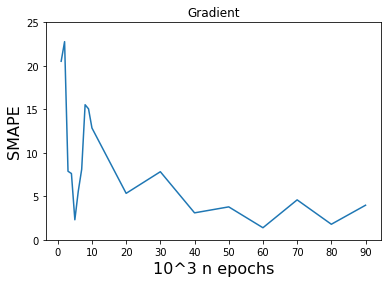

In [56]:
%matplotlib inline
plt.plot([ s/100 for s in grad_x_plot], grad_y_plot)
plt.title("Gradient")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('10^3 n epochs', fontsize=16)
plt.xticks(list(range(0,100,10)))
plt.yticks(list(range(int(min(grad_y_plot)//5)*5, int(max(grad_y_plot)//5 +2)*5,5)))
plt.show()

In [84]:
reg.genetic()
print(reg.nrmse_score())
print(reg.smape_score())

0.0005052177893395452
0.28380629240613653


In [85]:
genetic_x_plot = list(range(40))
genetic_y_plot = []
for n_epochs in genetic_x_plot:
    print(n_epochs, end='... ')
    reg.genetic(n_epochs=n_epochs)
    genetic_y_plot.append(reg.smape_score())
    print(' '.join(map(str, genetic_y_plot)))


0... 23.862566946528446
1... 23.862566946528446 3.4676332684280697
2... 23.862566946528446 3.4676332684280697 4.342922013598297
3... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158
4... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696
5... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246
6... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246 3.2025028026569613
7... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246 3.2025028026569613 2.115287870567201
8... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246 3.2025028026569613 2.115287870567201 1.7771375553143405
9... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.70106123

29... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246 3.2025028026569613 2.115287870567201 1.7771375553143405 3.192868090915782 2.0975977877718606 2.460643898107567 0.24435538672404172 2.097842489767604 1.4226393062816824 2.2297733653877208 2.3294281609979497 1.9364051056824843 0.5345449457870305 1.0182381979542694 0.39640684569612866 1.0958166198214672 0.9559537359658747 0.6249066325258499 1.89185603756344 0.6623684132418081 0.8229708712867317 0.41877493314088565 1.4144248872137877 1.0979880182608863
30... 23.862566946528446 3.4676332684280697 4.342922013598297 1.7923630838235158 3.9311317071424696 1.7010612334911246 3.2025028026569613 2.115287870567201 1.7771375553143405 3.192868090915782 2.0975977877718606 2.460643898107567 0.24435538672404172 2.097842489767604 1.4226393062816824 2.2297733653877208 2.3294281609979497 1.9364051056824843 0.5345449457870305 1.0182381979542694 0.39640684569612866 1.0958166198214672 0.95595

In [ ]:
genetic_x_plot_copy = genetic_x_plot.copy()
genetic_y_plot_copy = genetic_y_plot.copy()

TypeError: list expected at most 1 argument, got 2

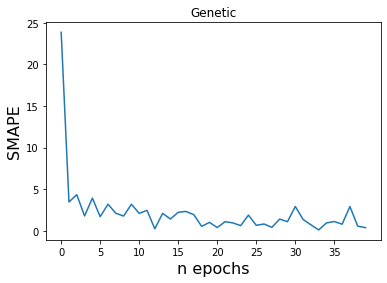

In [90]:
%matplotlib inline
plt.plot(genetic_x_plot, genetic_y_plot)
plt.title("Genetic")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.xticks(list(range(0,40,5)))
plt.yticks(list(range(int(min(genetic_y_plot)//5)*5, int(max(genetic_y_plot)//5+2)*5), 5))
plt.show()